In [46]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.io import mmread
from anndata import AnnData
import matplotlib.pyplot as plt

sc.settings.verbosity = 2

## Load Data

In [2]:
# read in sarah's data
REF='/mnt/monica/quaranta/Data/RNAseq/SCLC_data/SCLC_scRNAseq/SCLC-human-cell-lines-Vanderbilt/adata_no_doublets_02.h5ad'

In [4]:
sc.settings.set_figure_params(dpi=80)

In [5]:
adata = sc.read_h5ad(REF)
adata

AnnData object with n_obs × n_vars = 13945 × 20446
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'cline', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_scores_ind', 'predicted_doublets_ind', 'M', 'E', 'clusters_gradients', 'cell_cycle_diff', 'score'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'dropkick_coef-CORL279', 'dropkick_coef-DMS454', 'dropkick_coef-DMS53', 'dropkick_coef-H1048', 'dropkick_coef-H524', 'dropkick_coef-H69', 'dropkick_coef-H82', 'dropkick_coef-H841', 'mito', 'pct_dropout_by_counts', 'ambient', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'total_counts', 'log1p_

13,945 cells × 20,446 genes  
`adata.var_names` are gene names `adata.obs_names` are cell IDs (barcodes) and cell line identifiers

In [7]:
adata.var_names

Index(['MT-ND4', 'MT-ND3', 'MT-CO3', 'RPS19', 'MT-RNR2', 'MT-ND1', 'MT-ND2',
       'MT-ATP6', 'MT-CYB', 'HIST1H4C',
       ...
       'FER1L6', 'AL136531.1', 'RN7SL753P', 'HMGN2P39', 'SERBP1P4',
       'RP11-122A21.2', 'KB-1507C5.4', 'LINC00376', 'TERF1P5', 'GLRA4'],
      dtype='object', name='Gene', length=20446)

In [ ]:
adata.obs_names

In [ ]:
adata.obs.columns

### Reading Counts Matrix 
The MTX format is a sparse matrix format with genes on the rows and cells on the columns as output by Cell Ranger (`8056-AW-0001_S1_L005_counts.mtx`)  

You should also have TSV files with genes (`8056-AW-0001_S1_L005_features.tsv`) and barcode sequences (`8056-AW-0001_S1_L005_barcodes.tsv`) corresponding to row and column indices, respectively  

| Sample Info | Output Dir |
| ------------| ------------|
| S1 H841_KOR  | 8056-AW-0001 |
| S2 H841_RESTko | 8056-AW-0002 |
| S3 H841_Hes1ko | 8056-AW-0003 | 
| S4 H841_NR0B1ko | 8056-AW-0004 |
| S5 H841_ELF3ko | 8056-AW-0005 |
| S1 DMS53_KOR | 8056-AW-0006 |
| S2 DMS53_RESTko | 8056-AW-0007 |
| S3 DMS53_Hes1ko | 8056-AW-0008 |
| S4 DMS53_NR0B1ko | 8056-AW-0009 |
| S5 DMS53_ELF3ko | 8056-AW-0010 |

In [43]:
MTX_DIR = '/mnt/monica/quaranta2/Sequence_data_from_VANTAGE/CW-AW_data/processed_data_Qi_Liu'
sample_names = os.listdir(MTX_DIR)
sample_names.sort()
# print(samples)
sample_names = sample_names[2:12]
# print(samples)

In [44]:
test = f'{MTX_DIR}/{sample}/cm_sparse/{sample}_S1_L005_matrix.mtx'
print(test)

/mnt/monica/quaranta2/Sequence_data_from_VANTAGE/CW-AW_data/processed_data_Qi_Liu/8056-AW-0010/cm_sparse/8056-AW-0010_S1_L005_matrix.mtx


In [52]:
# H841 - samples[0:5]
# DMS53 - samples[5:10]
cache = False
cache_compression = None
samples = []

for sample in sample_names[5:10]:
    print(sample)
    s = sc.read(
        f'{MTX_DIR}/{sample}/cm_sparse/{sample}_S1_L005_counts.mtx',
        cache=cache,
        cache_compression=cache_compression,
    ).T
    
    genes = pd.read_csv(f'{MTX_DIR}/{sample}/cm_sparse/{sample}_S1_L005_features.tsv', header=None, sep='\t')
    s.var_names = genes[0]
    # s.var['gene_symbols'] = genes[1].values
    s.obs_names = pd.read_csv(f'{MTX_DIR}/{sample}/cm_sparse/{sample}_S1_L005_barcodes.tsv', header=None)[0]
    print(s)
    samples.append(s)

8056-AW-0006
AnnData object with n_obs × n_vars = 12622 × 25828
8056-AW-0007
AnnData object with n_obs × n_vars = 13303 × 25856
8056-AW-0008
AnnData object with n_obs × n_vars = 5038 × 24030
8056-AW-0009
AnnData object with n_obs × n_vars = 7962 × 26426
8056-AW-0010
AnnData object with n_obs × n_vars = 10536 × 26090


normalizing counts per cell
    finished (0:00:00)


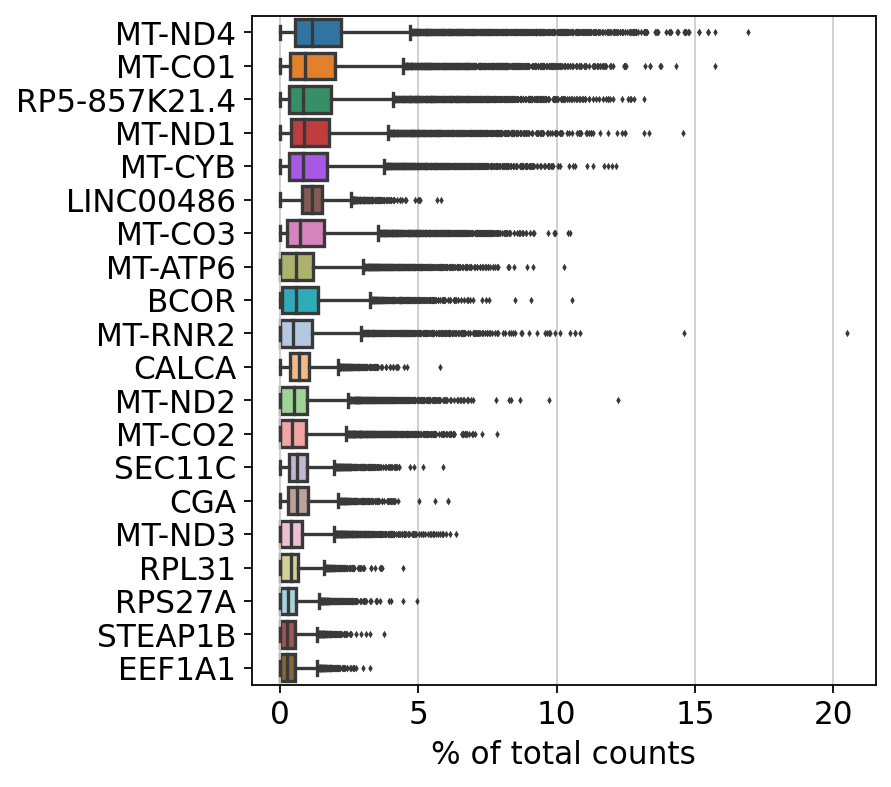

In [62]:
sc.pl.highest_expr_genes(samples[0], n_top=20, )

In [ ]:
s1, s2, s3, s4, s5 = samples
dms53_adata = AnnData.concatenate(s1, s2, s3, s4, s5)

## Preprocessing

normalizing counts per cell
    finished (0:00:00)


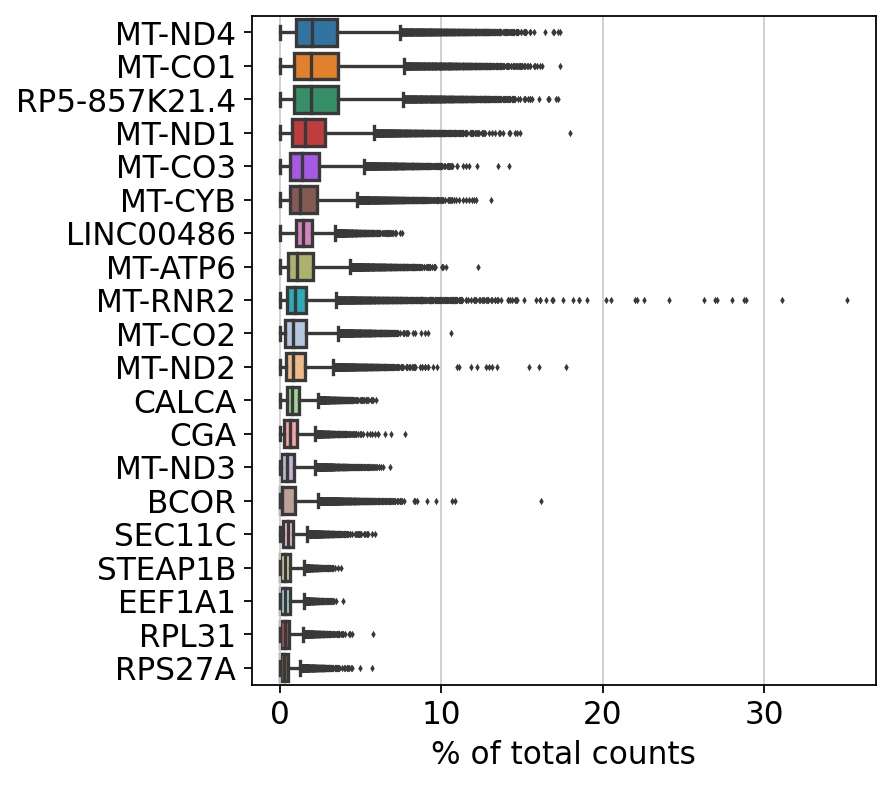

In [70]:
sc.pl.highest_expr_genes(dms53_adata, n_top=20, )

In [48]:
dms53_adata

/home/monica/miniconda/envs/rna-seq/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


AnnData object with n_obs × n_vars = 49461 × 21758
    obs: 'batch'

In [72]:
sc.pp.filter_cells(dms53_adata, min_genes=200)
sc.pp.filter_genes(dms53_adata, min_cells=3)

filtered out 18518 cells that have less than 200 genes expressed


In [73]:
dms53_adata

AnnData object with n_obs × n_vars = 30943 × 21758
    obs: 'batch', 'n_genes'
    var: 'n_cells'

In [74]:
dms53_adata.var['mt'] = dms53_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'

In [75]:
dms53_adata.var

,n_cells,mt
RAP2C,743,False
AIFM1,2398,False
BEX1,10021,False
RAPGEF4,1758,False
WHSC1L1,4480,False
...,...,...
TMEM210,8,False
RP11-622A1.2,13,False
RP11-463I20.2,16,False
LBP,15,False


In [76]:
dms53_adata.var[dms53_adata.var.mt == True]

,n_cells,mt
MT-ND4,30213,True
MT-CYB,29371,True
MT-ND1,29721,True
MT-RNR2,28281,True
MT-ND2,28385,True
MT-CO3,29363,True
MT-CO1,29930,True
MT-ND3,26006,True
MT-ND5,14909,True
MT-CO2,27619,True


In [77]:
dms53_adata

AnnData object with n_obs × n_vars = 30943 × 21758
    obs: 'batch', 'n_genes'
    var: 'n_cells', 'mt'

In [78]:
sc.pp.calculate_qc_metrics(dms53_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [79]:
dms53_adata

AnnData object with n_obs × n_vars = 30943 × 21758
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [80]:
dms53_adata.obs

,batch,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
TAGCTTATTGTAGTTT-0,0,200,200,224.0,11.0,4.910714
ACTTCAATCGTATTTC-0,0,200,200,224.0,16.0,7.142858
TGACAATACTTCAGTCCCT-0,0,200,200,224.0,10.0,4.464286
GAATTGGGCCTTCCAGAC-0,0,200,200,225.0,5.0,2.222222
GACAATTAGTCCCATAGC-0,0,200,200,225.0,10.0,4.444445
...,...,...,...,...,...,...
GATGTTCCAGGTCCATGT-4,4,7103,7103,30890.0,3597.0,11.644546
GATGTGAGACCTTCTT-4,4,7172,7172,30621.0,1152.0,3.762124
GGCCCTTAAGGCAGTT-4,4,7691,7691,33761.0,4328.0,12.819526
CTTTAATCATGAAGCA-4,4,7747,7747,35837.0,3644.0,10.168262


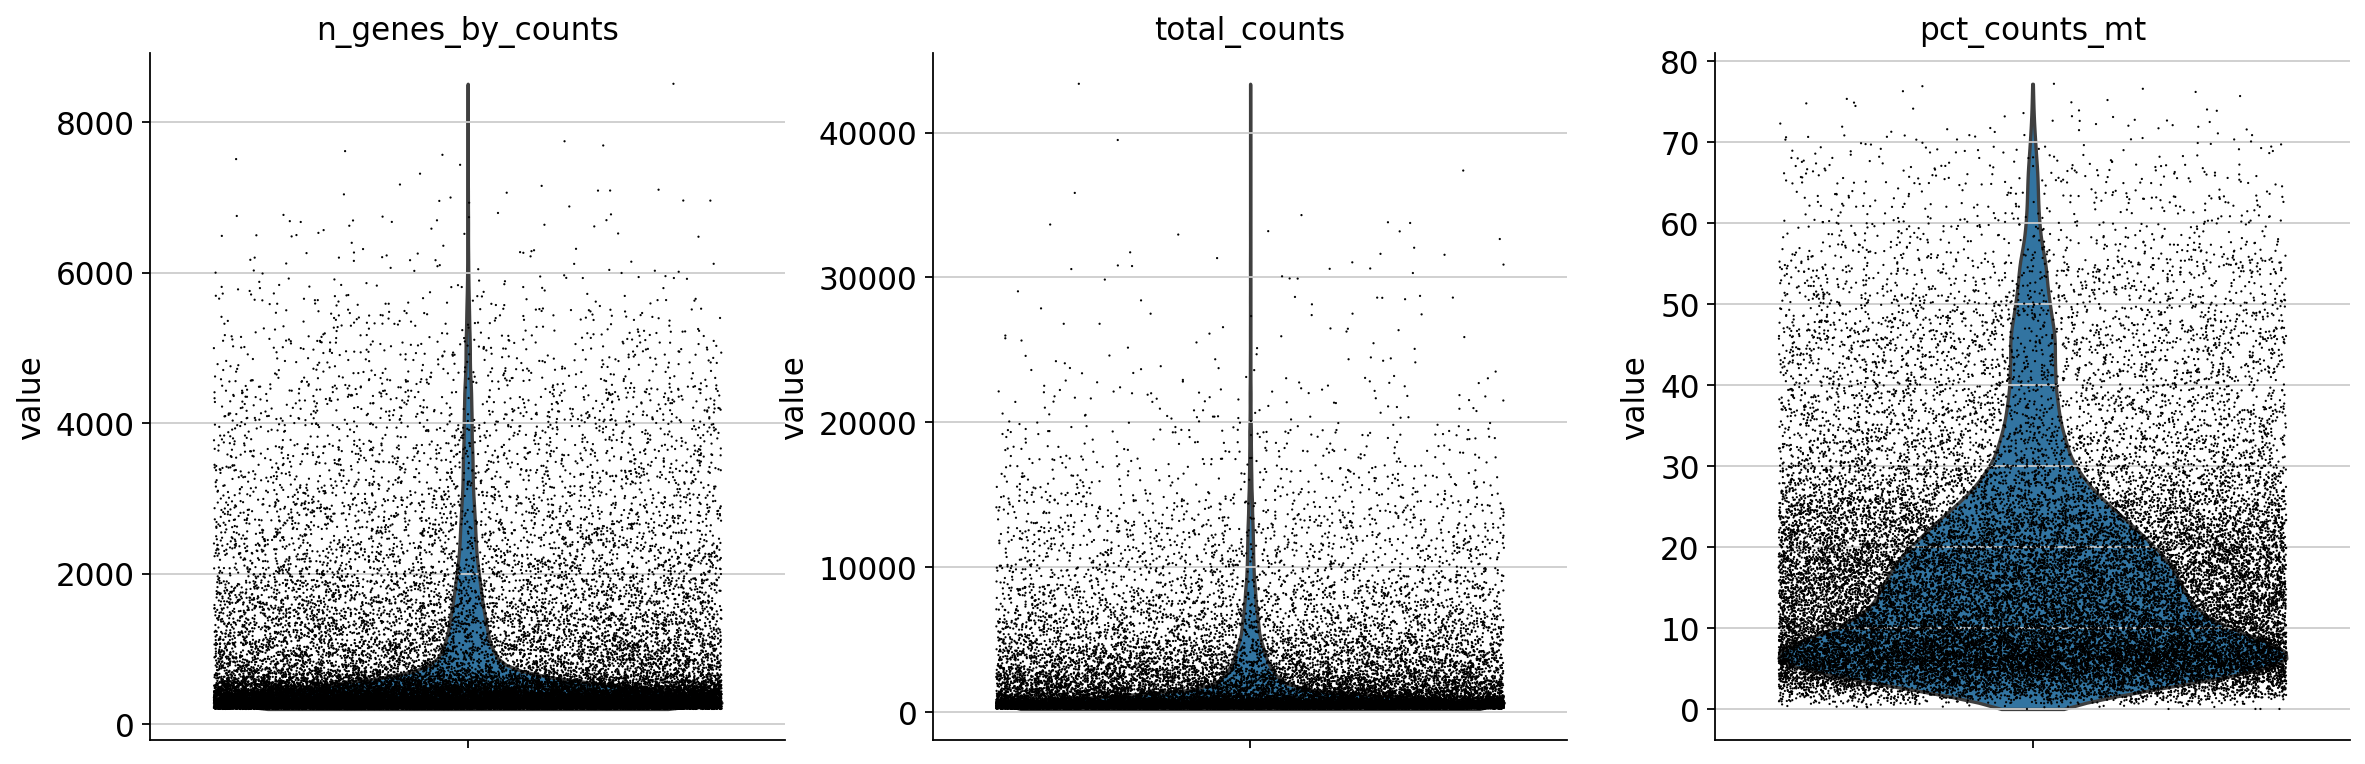

In [82]:
sc.pl.violin(dms53_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

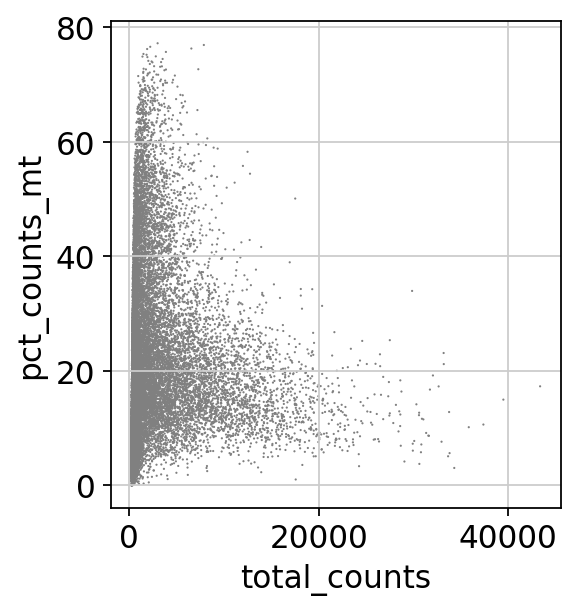

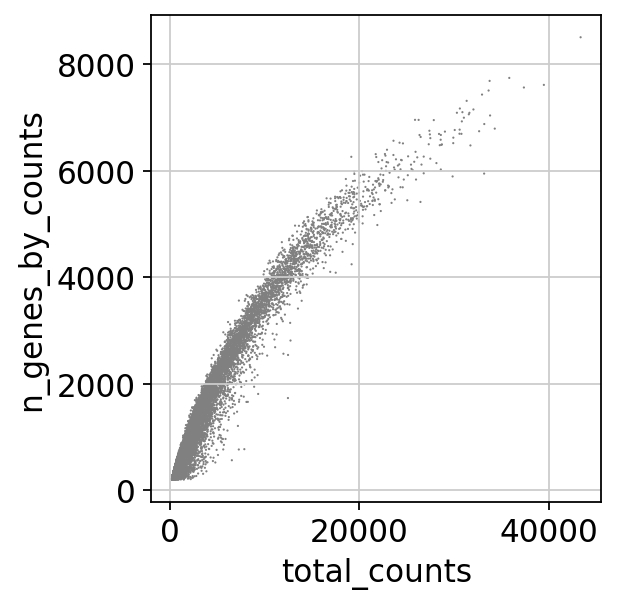

In [83]:
sc.pl.scatter(dms53_adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(dms53_adata, x='total_counts', y='n_genes_by_counts')

In [86]:
# filtering by quantile instead of picking a limit and slicing, like in the tutorial 
# (https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html)
# adata = adata[adata.obs.n_genes_by_counts < 2500, :]
# adata = adata[adata.obs.pct_counts_mt < 5, :]

upper_lim = np.quantile(dms53_adata.obs.n_genes_by_counts.values, .98)
lower_lim = np.quantile(dms53_adata.obs.n_genes_by_counts.values, .02)
print(f'{lower_lim} to {upper_lim}')

205.0 to 4427.16


In [87]:
# filtering by upper and lower limits
dms53_adata = dms53_adata[(dms53_adata.obs.n_genes_by_counts < upper_lim) & (dms53_adata.obs.n_genes_by_counts > lower_lim)]
# adata = adata[adata.obs.pct_counts_mt < 5, :] --> Not sure what cut off to use to filter the mt counts

In [90]:
dms53_adata.X[1,:].sum() # before normalizing

226.0

In [91]:
sc.pp.normalize_total(dms53_adata, target_sum=1e4) # normalize every cell to 10,000 UMI

normalizing counts per cell
    finished (0:00:00)


/home/monica/miniconda/envs/rna-seq/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [92]:
dms53_adata.X[1,:].sum() # after normalizing

9999.989

In [93]:
sc.pp.log1p(dms53_adata) # change to log counts

## Clustering

In [94]:
sc.pp.highly_variable_genes(dms53_adata, min_mean=0.0125, max_mean=3, min_disp=0.5) # default values

extracting highly variable genes
    finished (0:00:01)


In [96]:
dms53_adata.var[dms53_adata.var.highly_variable] # filter highly variable

,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm
RAP2C,743,False,743,0.026920,97.598811,833.0,True,0.126538,3.018529,0.684388
BEX1,10021,False,10021,0.777494,67.614646,24058.0,True,1.732822,3.171344,0.950013
MDH1,8262,False,8262,0.514333,73.299292,15915.0,True,1.495288,3.193161,0.658745
SEC63,2940,False,2940,0.130950,90.498659,4052.0,True,0.580207,3.147544,1.519215
LDHA,13622,False,13622,1.191707,55.977119,36875.0,True,2.182751,3.221668,1.914500
...,...,...,...,...,...,...,...,...,...,...
RP3-522D1.1,96,False,96,0.003264,99.689752,101.0,True,0.014955,3.532668,2.098016
RP11-399K21.14,85,False,85,0.003264,99.725301,101.0,True,0.014711,3.257071,1.340263
ANKRD45,81,False,81,0.002682,99.738228,83.0,True,0.014061,3.266115,1.365128
PPP1R3C,62,False,62,0.002456,99.799632,76.0,True,0.013737,3.325518,1.528456


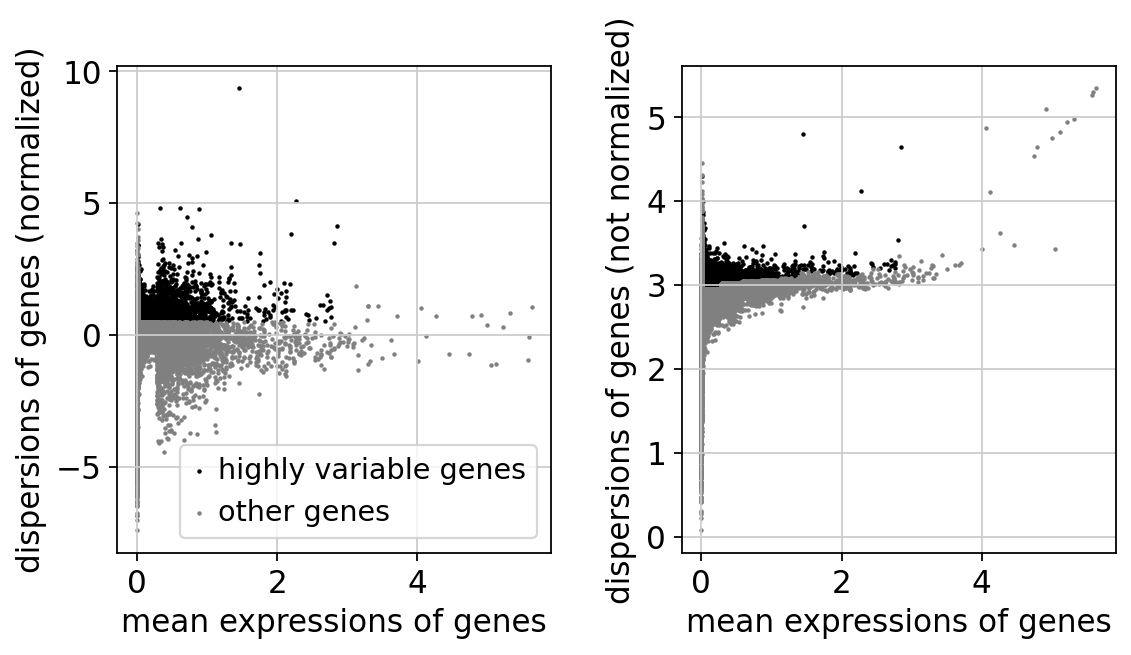

In [97]:
sc.pl.highly_variable_genes(dms53_adata)

In [98]:
dms53_adata.raw = dms53_adata # save raw data before processing and filtering further

In [99]:
dms53_adata = dms53_adata[:, dms53_adata.var.highly_variable] # filter highly variable

In [100]:
dms53_adata

View of AnnData object with n_obs × n_vars = 29654 × 4845
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [101]:
# regress out effects of total counts per cell and percentage of mitochondrial genes expressed
sc.pp.regress_out(dms53_adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:01:36)


In [102]:
sc.pp.scale(dms53_adata, max_value=10) # scale each gene to unit variance

In [103]:
dms53_adata.X.min()

-3.3357964

In [104]:
dms53_adata.raw.X.min()

0.0

### Prinicipal Component Analysis

In [105]:
sc.tl.pca(dms53_adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:29)


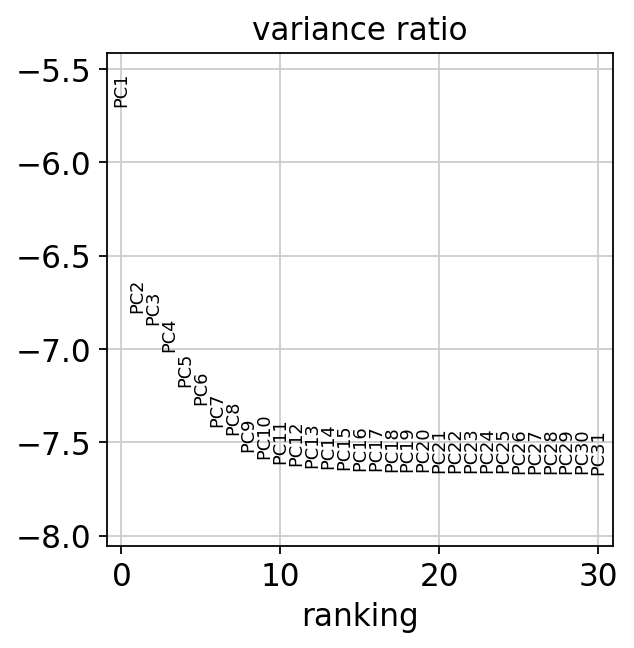

In [106]:
sc.pl.pca_variance_ratio(dms53_adata, log=True)

In [107]:
adata.write('/home/monica/rna_seq/dms53_adata.h5ad')

### Neighborhood Graph

In [108]:
sc.pp.neighbors(dms53_adata, n_neighbors=10, n_pcs=30)

computing neighbors
    using 'X_pca' with n_pcs = 30


/home/monica/miniconda/envs/rna-seq/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished (0:00:27)


In [110]:
sc.tl.umap(dms53_adata)

computing UMAP
    finished (0:00:19)


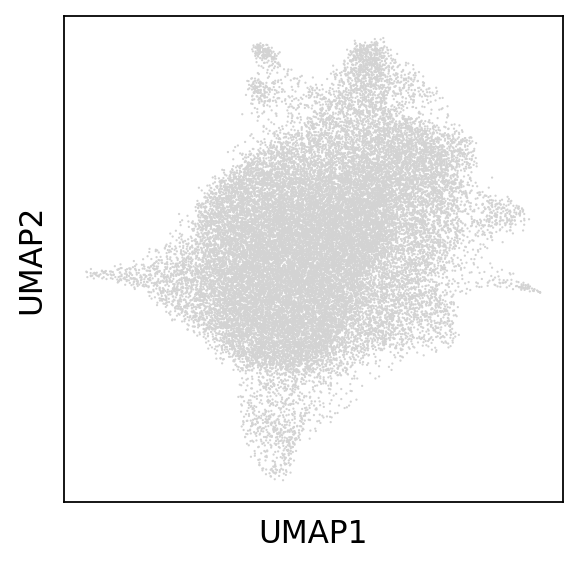

In [111]:
sc.pl.umap(dms53_adata)

running Leiden clustering
    finished (0:00:06)


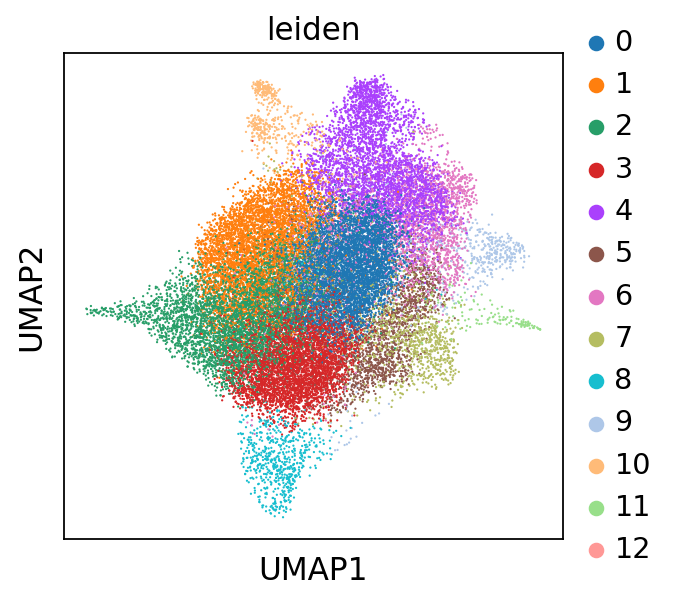

In [112]:
sc.tl.leiden(dms53_adata) # not sure if resolution needs to be specified here
sc.pl.umap(dms53_adata, color=['leiden'])